In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

from multicollinearityElimination.CliqueFinder import CliqueFinder

import matplotlib.pyplot as plt
import seaborn as sns

seed = 5

threshold = 0.8

## First look

In [2]:
boston_dataset = load_boston(return_X_y=False)

In [3]:
boston_data = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston_target =  boston_dataset.target

In [4]:
print(boston_dataset['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston_data.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [6]:
boston_data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


## Train test split

In [7]:
train_data, val_data, train_target, val_target = train_test_split(boston_data, 
                                                                boston_target,
                                                                test_size = 0.2, 
                                                                random_state=seed)

# EDA

<AxesSubplot:ylabel='Count'>

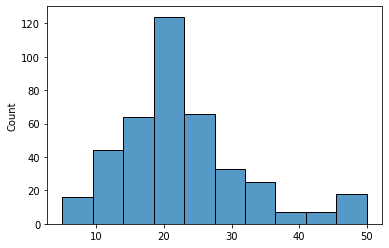

In [8]:
sns.histplot(train_target, bins = 10)

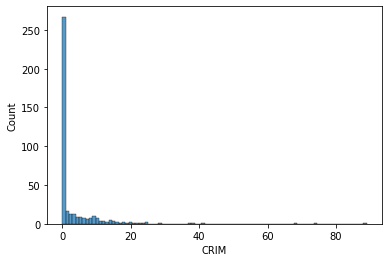

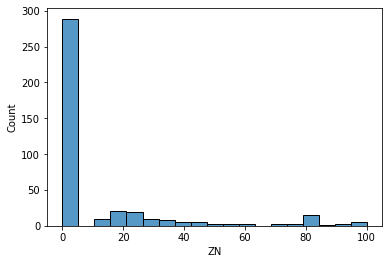

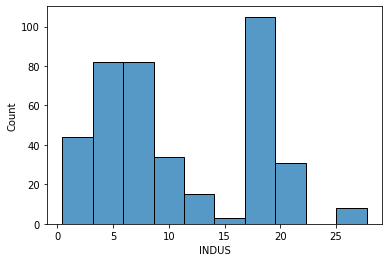

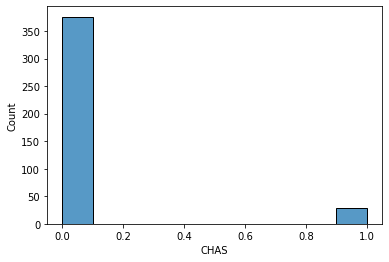

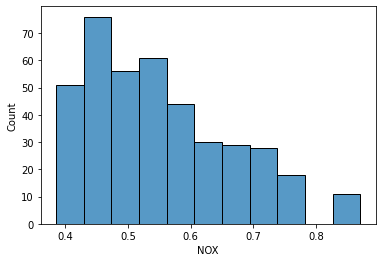

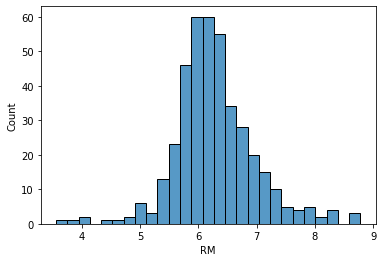

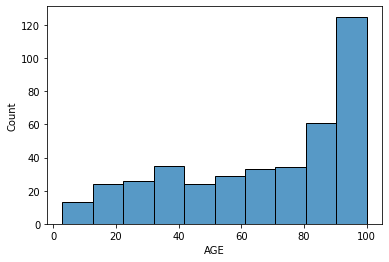

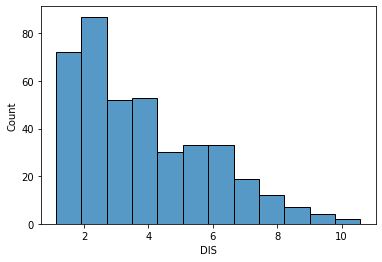

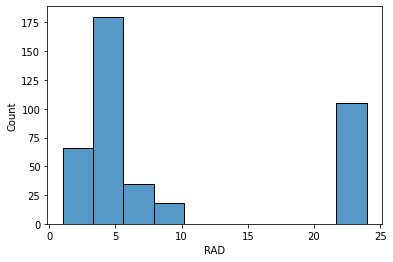

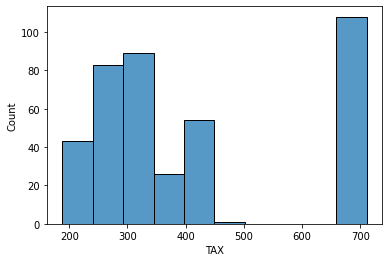

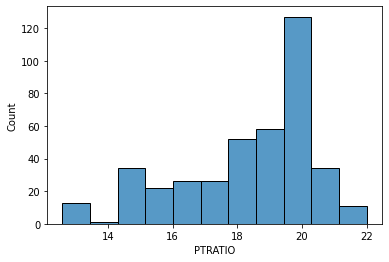

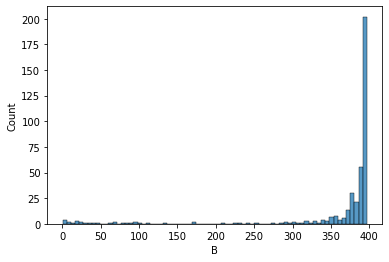

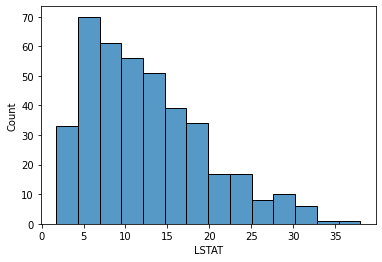

In [9]:
for feature_obj in train_data.select_dtypes(include=['int64','float64']).columns:
    sns.histplot(x=train_data[feature_obj])
    plt.show()

In [10]:
train_data['DIS'] = np.log(train_data['DIS'] + 1)
train_data['NOX'] = np.log(train_data['NOX'] + 1)

val_data['DIS'] = np.log(val_data['DIS'] + 1)
val_data['NOX'] = np.log(val_data['NOX'] + 1)

<ipython-input-10-184e4ce3c63c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['DIS'] = np.log(train_data['DIS'] + 1)
<ipython-input-10-184e4ce3c63c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['NOX'] = np.log(train_data['NOX'] + 1)
<ipython-input-10-184e4ce3c63c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## outliers remove

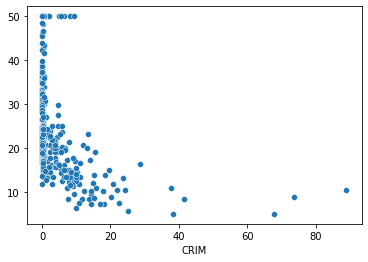

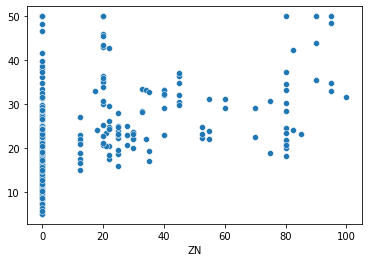

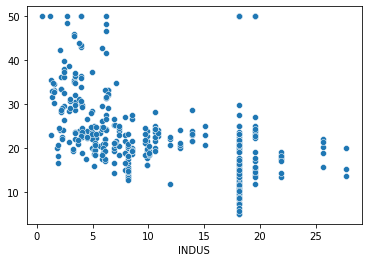

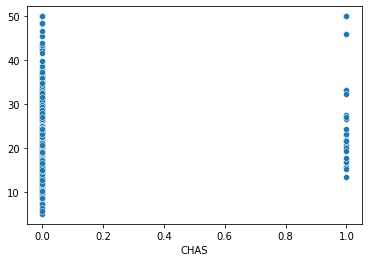

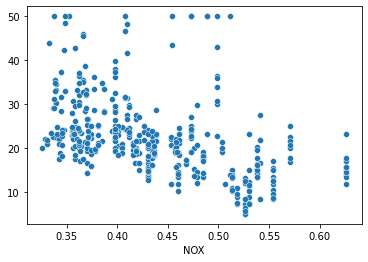

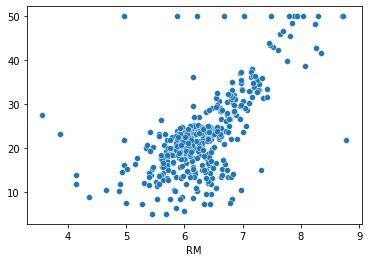

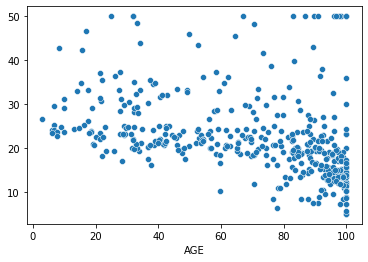

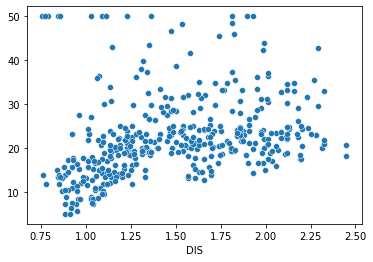

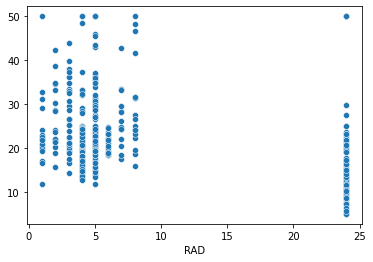

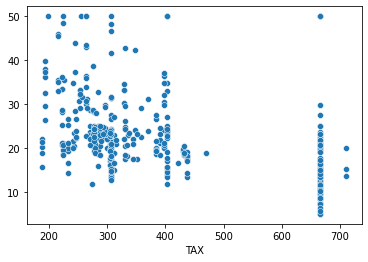

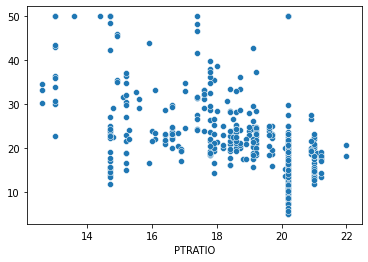

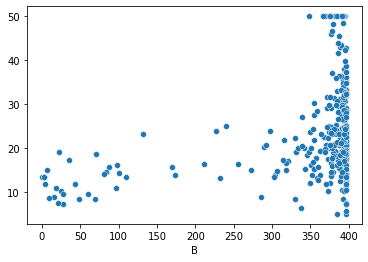

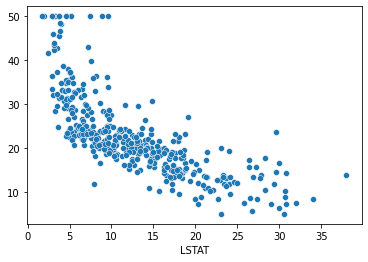

In [11]:
for feature_obj in train_data.select_dtypes(include=['int64','float64']).columns:
    sns.scatterplot(x=train_data[feature_obj], y=train_target)
    plt.show()

In [12]:
valid_train = train_data['CRIM'] < 60
valid_validation = val_data['CRIM'] < 60
train_data = train_data[valid_train]
train_target = train_target[valid_train]
val_data = val_data[valid_validation]
val_target = val_target[valid_validation]

## Feature elimination

In [13]:
pval = 0.01
corr_threshold = 0.1
excluded_features = []
for feature in train_data.columns:
    result = stats.spearmanr(boston_data[feature], boston_target)
    feat_corr = result[0]
    feat_pval = result[1]
    print("name: {} corr: {} pval: {}".format(feature, feat_corr, feat_pval))
    if np.abs(feat_pval) > pval or np.abs(feat_corr) < corr_threshold:
        excluded_features.append(feature)

boston_data = boston_data.drop(columns=excluded_features)

name: CRIM corr: -0.5588909488368801 pval: 6.5533358892281775e-43
name: ZN corr: 0.4381789640559852 pval: 3.740000913425908e-25
name: INDUS corr: -0.5782553852030439 pval: 1.7372313174421995e-46
name: CHAS corr: 0.14061215382621473 pval: 0.0015194793433759603
name: NOX corr: -0.5626088297953195 pval: 1.4059853091979118e-43
name: RM corr: 0.6335764254337745 pval: 3.822976266954402e-58
name: AGE corr: -0.5475616874543465 pval: 6.343734710404128e-41
name: DIS corr: 0.4458568541441564 pval: 4.387641750154636e-26
name: RAD corr: -0.3467762570566875 pval: 9.604183972208833e-16
name: TAX corr: -0.5624106263737141 pval: 1.526974080503951e-43
name: PTRATIO corr: -0.5559046822691174 pval: 2.224971669470621e-42
name: B corr: 0.18566412252480774 pval: 2.637767864062266e-05
name: LSTAT corr: -0.8529141394922163 pval: 2.221727524313283e-144


In [14]:
excluded_features

[]

In [15]:
corr_matrix = train_data.corr(method ='spearman')
# spearman pearson

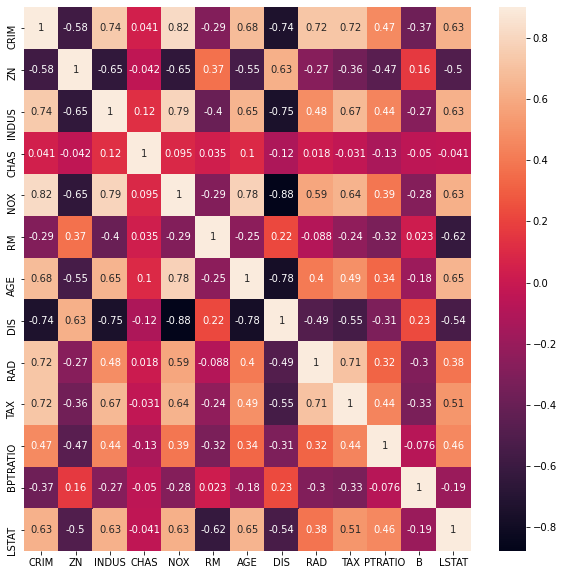

In [16]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix,vmax = 0.9, annot = True);

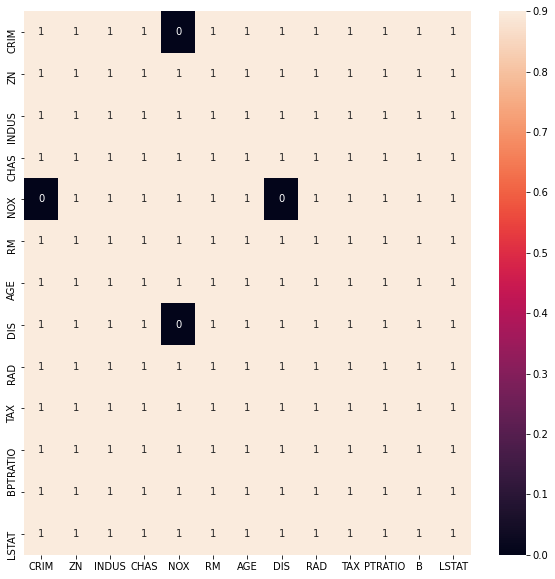

In [17]:
corr_matrix_th = corr_matrix.applymap(lambda x: 0 if (np.abs(x) > threshold) else 1)
n = len(corr_matrix_th)
for i in range(n):
    corr_matrix_th.iloc[i,i]=1
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(corr_matrix_th,vmax = 0.9, annot = True);

In [18]:
#corr_func = lambda x,y: stats.pearsonr(x,y)[0]
corr_func = lambda x,y: stats.spearmanr(x,y)[0] 

In [19]:
CliqFinderObj = CliqueFinder(corr_matrix, train_data, train_target)

In [20]:
CliqFinderObj.fit(feature_target_corr_func=corr_func, threshold=threshold)

In [21]:
best_features_subset = CliqFinderObj.get_best_clique()
features_to_exclude = CliqFinderObj.get_out_of_clique_features()

In [22]:
#new_boston_data = boston_data[best_features_subset]
new_train_data = train_data.drop(columns=features_to_exclude)
new_val_data = val_data.drop(columns=features_to_exclude)
new_train_data.shape

(401, 12)

In [23]:
new_corr_matrix = new_train_data.corr()

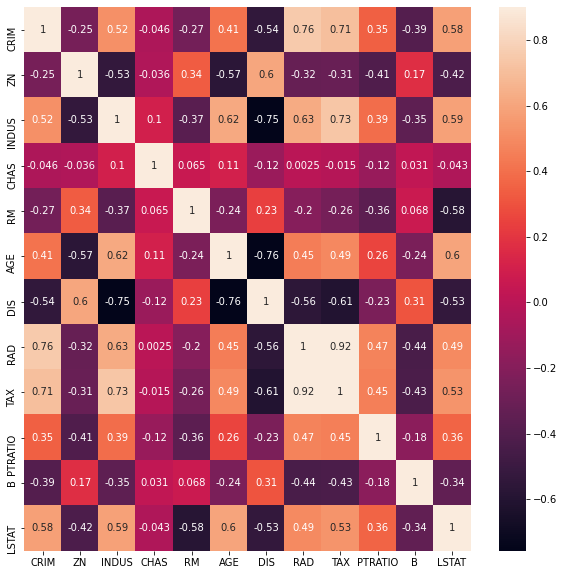

In [24]:
f, ax1 = plt.subplots(figsize=(10,10)) 
ax1=sns.heatmap(new_corr_matrix,vmax = 0.9, annot = True);

## Pipeline Setup & ML model train

In [25]:
all_columns = list(new_train_data.columns)
num_columns = all_columns.copy()
num_columns.remove("CHAS")

In [26]:
modifiedRegressor = TransformedTargetRegressor(
    regressor = LinearRegression(),
    func = lambda x: np.log(x+1),
    inverse_func = lambda x: np.exp(x) - 1
)

feature_prepr = ColumnTransformer(
     transformers = [("numerical", StandardScaler(), num_columns)],
     remainder="passthrough"
)

pipeline = Pipeline(steps = [
    ('featurePrepr', feature_prepr),
    ('Estimator', modifiedRegressor)
])

In [27]:
pipeline.fit(new_train_data, train_target)

Pipeline(steps=[('featurePrepr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical', StandardScaler(),
                                                  ['CRIM', 'ZN', 'INDUS', 'RM',
                                                   'AGE', 'DIS', 'RAD', 'TAX',
                                                   'PTRATIO', 'B',
                                                   'LSTAT'])])),
                ('Estimator',
                 TransformedTargetRegressor(func=<function <lambda> at 0x000001C43D041430>,
                                            inverse_func=<function <lambda> at 0x000001C43D0414C0>,
                                            regressor=LinearRegression()))])

In [28]:
prediction_value = pipeline.predict(new_val_data)
rmse = mean_squared_error(val_target, prediction_value, squared=False)
r2_score_value = r2_score(val_target, prediction_value)
print("RMSE: {} R2_Score: {}".format(rmse, r2_score_value))

RMSE: 3.945411444853383 R2_Score: 0.8011814752958262


## Post-Hoc analysis

In [29]:
error = prediction_value - val_target

<AxesSubplot:ylabel='Count'>

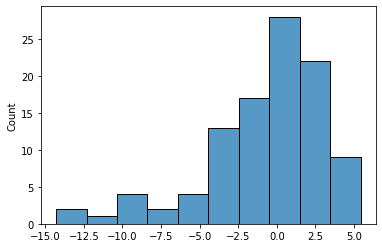

In [30]:
sns.histplot(error, bins=10)